### Import Modules

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

# Class

In [366]:
class idm_multilane():
    
    def parameters(self, v0, T, a, b, delta, lc, s0, s1, lr):
        self.v0 = v0
        self.T = T
        self.a = a
        self.b = b
        self.delta = delta
        self.lc = lc
        self.s0 = s0
        self.s1 = s1
        self.lr = lr
    
    
    def initial_conditions(self, n_cars, x_init, v_init):
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
    
    
    def simulate(self, dt, t_final):
        n_cars_const = 4  # number of cars that cannot exit (to be monitored)
        
        ## store constant cars in the first n columns
        ind1 = np.round(np.linspace(0,self.n_cars,n_cars_const+1)[:-1])
        ind2 = np.arange(self.n_cars)
        ind2 = ind2[np.invert(np.in1d(ind2,ind1))]
        ind = np.append(ind1, ind2).astype(int)
        x0 = self.x_init[ind]
        v0 = self.v_init[ind]
        y0 = np.append(x0, v0)
        t = np.arange(0, t_final+dt, dt)
        
        ## solve differential equations
        sol = np.zeros((len(t), len(y0)))
        sol[0,:] = y0
        n_cars_tot = self.n_cars  # total number of cars to be in the lane
        n_cars_cur = np.append(self.n_cars, np.zeros(len(t)-1))  # current number of cars in the lane
        ind_cars = np.arange(self.n_cars)
        ordered_ind_cars = ind_cars[np.argsort(x0)[::-1]]
        
        for i in range(1,len(t)):
            # calculate next position and velocity of current cars in lane
            sol_i = odeint(self.idm, sol[i-1, np.append(ordered_ind_cars, ordered_ind_cars+n_cars_tot)], [0,dt])
            sol[i,np.append(ordered_ind_cars, ordered_ind_cars+n_cars_tot)] = sol_i[-1,:]
            
            # check each gap to see if a car is entering and/or exitting
            
            # length of gap in front of each car
            gaps = np.append(sol[i,ordered_ind_cars[-1]] - sol[i,ordered_ind_cars[0]] + self.lr,
                             sol[i,ordered_ind_cars[:-1]] - sol[i,ordered_ind_cars[1:]])
            
            # velocity of each car
            vel_cars_cur = sol[i, ordered_ind_cars+n_cars_tot]
            
            enter = self.prob_enter(gaps, 20)
            exit = self.prob_exit(gaps, 20)
            exit = np.logical_or(exit, np.in1d(ordered_ind_cars,np.arange(n_cars_const)))
            #print(exit)
            
            ind = np.where(enter)[0]
            
            if enter[0]:
                # if a car entered in front of the farthest car, use special equation
                x_new = np.append(1/2 * (sol[i, ordered_ind_cars[-1]] - sol[i, ordered_ind_cars[0]] + self.lr) + 
                                  sol[i, ordered_ind_cars[0]], 1/2 * (sol[i, ordered_ind_cars[ind[1:]]] +
                                                                      sol[i, ordered_ind_cars[ind[1:]-1]]))
            else:
                x_new = 1/2 * (sol[i, ordered_ind_cars[ind]] + sol[i, ordered_ind_cars[ind-1]])
                
            v_new = sol[i, ordered_ind_cars[ind]+n_cars_tot]
            
            sol = np.insert(sol, [n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
            sol = np.insert(sol, [sum(enter)+n_cars_tot+n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
            
            
            sol[i, np.arange(sum(enter))+n_cars_const] = x_new
            sol[i, np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = v_new
            
            # update indeces (whether change occured or not), and add cars (if change occured)            
            ind_cars = np.append(np.append(np.arange(n_cars_const), np.arange(sum(enter))+n_cars_const),
                                 ordered_ind_cars[np.invert(exit)]+sum(enter))
            
            n_cars_tot += sum(enter)
            n_cars_cur[i] = n_cars_cur[i-1] + sum(enter) - sum(exit) + n_cars_const
            
            # order the indeces by position
            ordered_ind_cars = ind_cars[np.argsort(sol[i, ind_cars])[::-1]]
        
        # keep position values between 0 and lr
        sol[:,:len(x0)] = np.mod(sol[:,:len(x0)], self.lr)
        
        return(sol, n_cars_cur)
    
    
    def idm(self, y, t):
        dydt = np.zeros(len(y))
        n = int(len(y)/2)
        
        for i in range(n):
            if i==0:
                ss = 1/(y[n-1] - y[0] - self.lc + self.lr)**2  # inverse square of bumper-to-bumper gap
                va = y[2*n-1]  # velocity of car ahead
            else:
                ss = 1/(y[i-1] - y[i] - self.lc)**2
                va = y[n+i-1]
            
            vc = y[n+i]  # velocity of current car
            
            dydt[i] = vc
            dydt[n+i] = self.a * (1 - (vc/self.v0)**self.delta 
                                  - ss*(self.s0
                                        + self.s1*np.sqrt(vc/self.v0)
                                        + self.T*vc 
                                        + 1/(2*np.sqrt(self.a*self.b))*vc*(va-vc))**2)
        
        return(dydt)
    
    
    def prob_enter(self, gaps, h):
        return(np.logical_and(gaps>h, np.random.rand(len(gaps))<0.025))
    
    
    def prob_exit(self, gaps, h):
        return(np.logical_and(gaps<h, np.random.rand(len(gaps))<0.05))

# Main

## Initialization

In [367]:
## initialize model
model = idm_multilane()

## define parameters of interest
v0 = 10/3     # desired velocity (m/s)
T = 1.6       # safe time headway (s)
a = 0.73      # maximum acceleration (m/s2)
b = 5/3       # comfortable decceleration (m/s2)
delta = 4     # acceleration exponent
lc = 4        # length of car (m)
s0 = 2        # linear jam distance (m)
s1 = 3        # non-linear jam distance (m)
lr = 1000     # length of road (m)

## fit parameters into model
model.parameters(v0=v0, T=T, a=a, b=b, delta=delta, lc=lc, s0=s0, s1=s1, lr=lr)

## Initial Conditions

### Free Traffic

In [368]:
## specify initial conditions
n_cars = 10  # number of cars
x_init = t = np.arange(0, lr, lr/n_cars)  # initial position of cars
v_init = np.zeros(n_cars)  # initial velocity of cars

## fit initial conditions into model
model.initial_conditions(n_cars=n_cars, x_init=x_init, v_init=v_init)

## Simulation


things to look at:
* vehicle (dynamic) stability -- acceleration profile
* convergence of velocity profiles -- variability of velocities

In [369]:
dt = 0.25      # update time (s)
t_final = 200  # simulation time (s)

## begin simulation
t1 = time.time()
sol, n_cars_cur = model.simulate(dt, t_final)
t2 = time.time()

print("Simulation Time:", t2-t1)

Simulation Time: 6.177292823791504


## Visualization

### Video

<IPython.core.display.Javascript object>


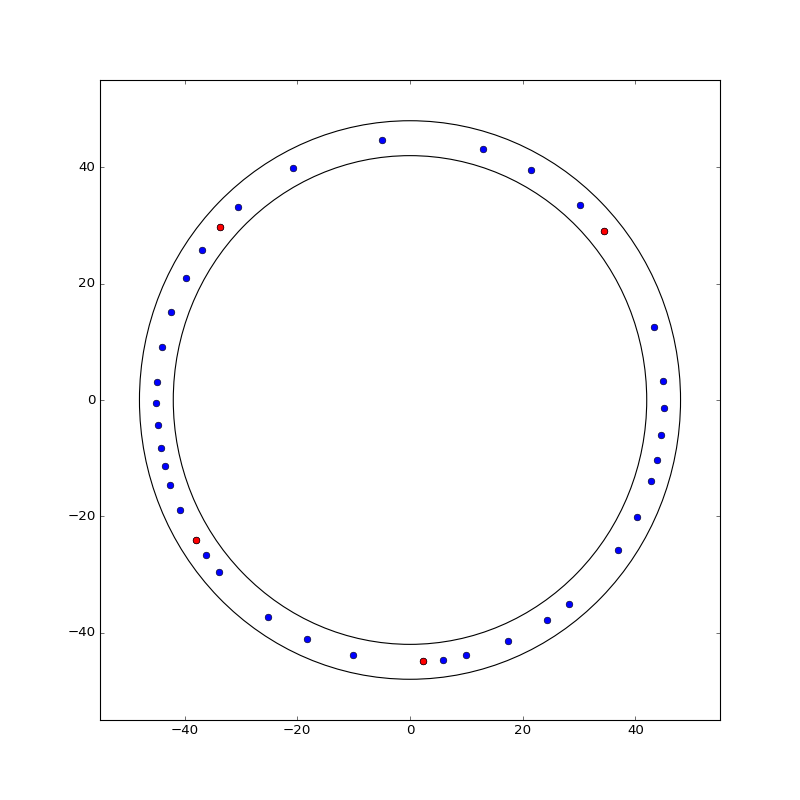

In [370]:
import time

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
pos_rad = np.divide(sol[:,:sol.shape[1]/2], lr) * 2*np.pi
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:4]!=0])
    li2.set_ydata(y[i,pos_rad[i,:4]!=0])

    
    fig.canvas.draw()
    #time.sleep(1)

### Position Profile

<IPython.core.display.Javascript object>


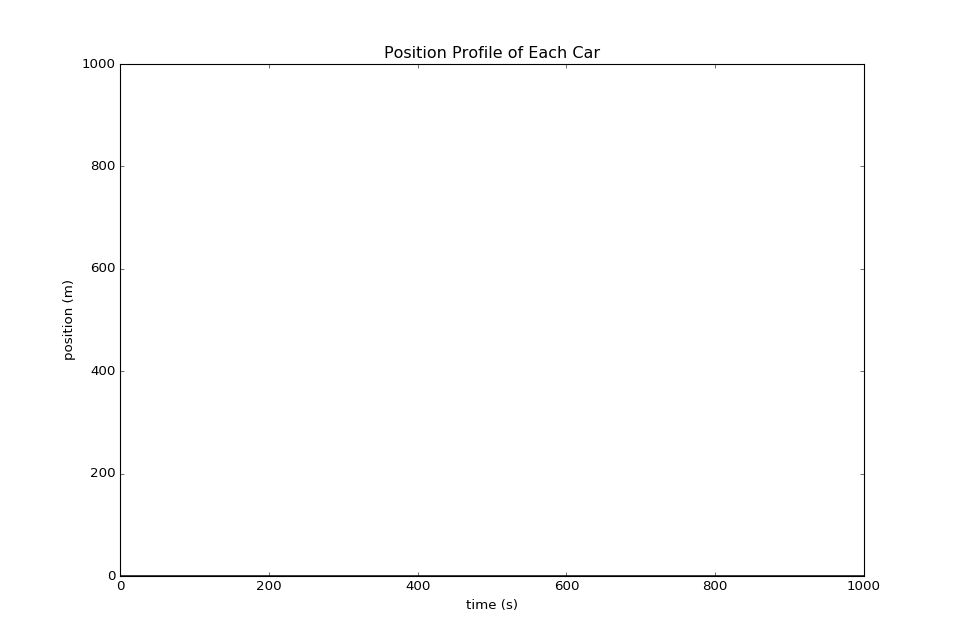

In [35]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(12,8))

for i in range(int(sol.shape[1]/2)):
    plt.plot(t, sol[:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

### Velocity Profile

<IPython.core.display.Javascript object>


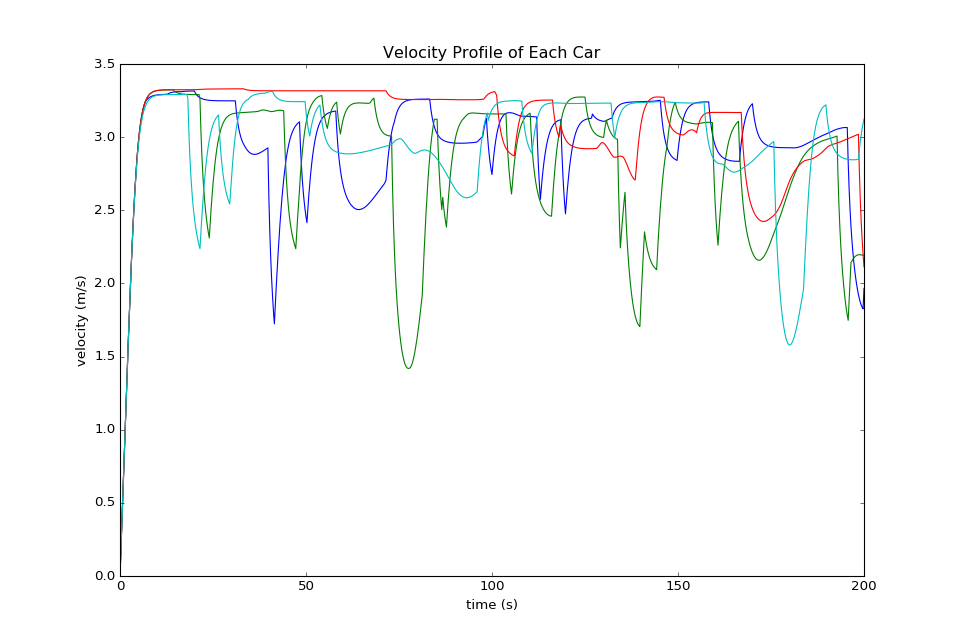

In [371]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(12,8))

for i in range(int(sol.shape[1]/2), int(sol.shape[1]/2)+4):
    plt.plot(t, sol[:,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

### Number of Cars vs. Time

<IPython.core.display.Javascript object>


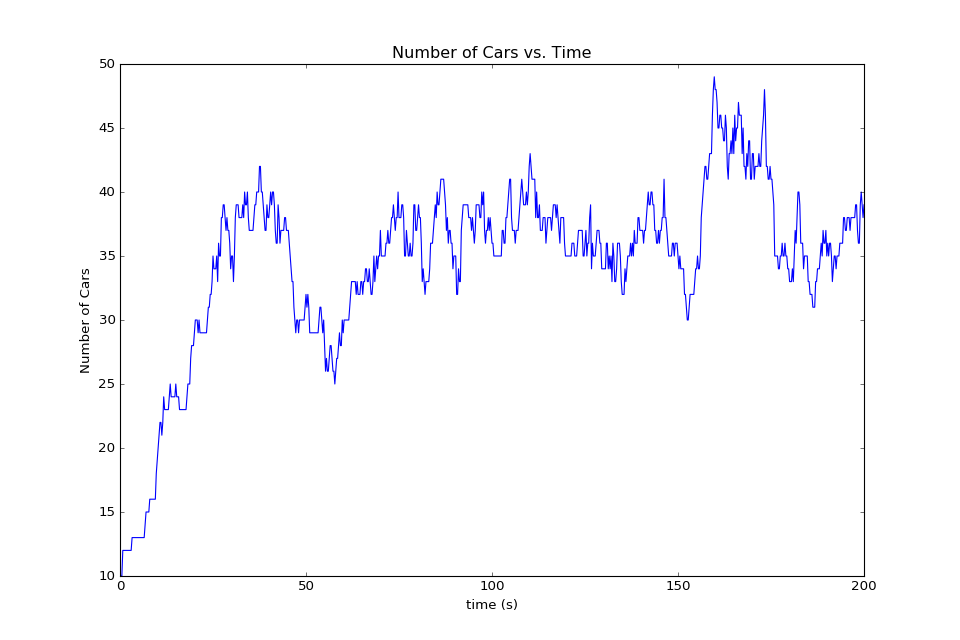

In [372]:
#num_cars = [len(ind_cars[i]) for i in range(len(ind_cars))]

t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(12,8))

plt.plot(t,n_cars_cur)

plt.title("Number of Cars vs. Time")
plt.xlabel('time (s)')
plt.ylabel('Number of Cars')
plt.show()